# Import everything

In [210]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm
import math
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
import gzip

# Power and phase calculations

In [211]:
def blackman_harris_filter(channel, time, cutoffs, fs, numtaps=801):
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def butter_bandpass_filter(data, lowcut, highcut, fs, btype='bandpass', order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    y = signal.lfilter(b, a, data)
    return y

def get_phase(channel, time, band, fs=4096, plot=False, filter_type='butter', start_time_ms=-750, stop_time_ms=-2):
    if filter_type=='butter':
        df_filtered = pd.DataFrame({'channel': butter_bandpass_filter(channel, band[0], band[1], 4096), 'time': time})
    else:
        df_filtered = blackman_harris_filter(channel, time, [0.000001, band[0]], fs)
        df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, band[1], fs)    
    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > start_time_ms) * (df_filtered['time'] < stop_time_ms)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > start_time_ms) * (df_filtered['time'] < stop_time_ms)]['time'].values
    
    if plot == True:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13,10))
        ax1.plot(time, channel)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Amplitude')
        ax1.set_title('Signal')
        
        ax2.plot(df_filtered['time'], df_filtered['channel'])
        ax2.set_title('Filtered channel')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Filtered channel')
        
        freq, power = signal.welch(df_filtered['channel'], 4096, nperseg=4096/2, nfft=4096/2)
        freq_res = freq[1] - freq[0]
        power = np.log(power)
        ax3.plot(freq[freq < 200], power[freq < 200])
        ax3.set_title('Power spectrum')
        ax3.set_xlabel('Frequency')
        ax3.set_ylabel('Power')
        
        ax4.plot(df_phase['time'], df_phase['phase'])
        ax4.plot(df_phase.iloc[-1]['time'], df_phase.iloc[-1]['phase'], 'o')
        ax4.set_title('Phase')
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Phase')
        plt.tight_layout()
    # df_phase = df_phase[df_phase['time'] <= -20]
    return df_phase.iloc[-1]['phase'] + 180

def get_power(channel, time, crop_start_millis=-150, fs=500, plot=False, method='pburg'):       
    # Crop.
    channel = channel[(time > crop_start_millis) * (time < -1)].values
    time = time[(time > crop_start_millis) * (time < -1)].values

    # Resample.
    ts = time[1] - time[0]
    secs = len(channel) * ts
    secs = secs/1000
    resampled = signal.resample(channel, int(secs*fs))
    resampled_time = np.linspace(time[0], time[-1], len(resampled))
    
    # Filer if gamma region.
#     if 48 > band[0] and 48 < band[1]:
#     if filter_type == 'butter':
#         resampled = butter_bandpass_filter(resampled, 48, 52, fs, 'bandstop')
#         resampled_time = resampled_time
#     else:
#         df_filtered = blackman_harris_filter(resampled, resampled_time, [48, 52], fs, numtaps=101)
#         resampled = df_filtered['channel']
#         resampled_time = df_filtered['time']
    
    # PSD.
    try:
        if method == 'welch':
            # Welch method
            freq, power = signal.welch(resampled, fs)
            freq_res = freq[1] - freq[0]
            df_power = pd.DataFrame({'freq': freq, 'power': power})
        elif method == 'fft':
            # FFT method
            power = np.abs(np.fft.fft(resampled, n=500))
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': power})
        elif method == 'pburg':
            # Burgs method
            p = pburg(resampled, int(len(resampled)*0.25), sampling=fs, NFFT=4096)
            power = p.psd
            freq = np.linspace(0, fs, len(power))
            df_power = pd.DataFrame({'freq': freq, 'power': power})
            df_power = df_power[df_power['freq'] < fs/2]
    except Exception as e: 
        print(e)
        return 0

    return df_power

In [212]:
eeg_files = glob.glob('data/alcoholism/*/*.gz')
print(len(eeg_files))
eeg_files[0:10]

11074


['data/alcoholism/co2c1000367/co2c1000367.rd.030.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.092.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.047.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.075.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.116.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.063.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.033.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.110.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.099.gz',
 'data/alcoholism/co2c1000367/co2c1000367.rd.001.gz']

In [213]:
def get_trial(trial_file):
    # Read the gzip file.
    with gzip.open(trial_file, 'rb') as f:
        trial_str = str(f.read(), 'utf-8')
    
    # Parse the file.
    df_long = []
    lines = trial_str.split('\n')
    if len(lines) < 10:
        return None
    sub = lines[0].split(' ')[1].split('.')[0].strip()
    alcoholic = sub[3] == 'a'
    condition = lines[3].split(',')[0][2:].strip()
    for line in lines[5:]:
        segments = line.split(' ')
        if segments[0] == '#' or len(segments) < 3:
            continue
        df_long.append({
            'subject': sub,
            'alcoholic': alcoholic,
            'condition': condition,
            'trial': int(segments[0]),
            'channel': segments[1],
            'sample': int(segments[2]),
            'value': float(segments[3])
        })
    df_long = pd.DataFrame(df_long)
    
    # Convert to wide format.
    df_wide = df_long.pivot_table(values=['value'], index=['subject', 'trial', 'sample', 'condition', 'alcoholic'], columns=['channel'])
    df_wide.columns = df_wide.columns.to_series().str[1]
    df_wide = df_wide.reset_index()
    
    # Add time column.
    df_wide['time'] = np.linspace(0, 1, df_wide.shape[0])
    
    # Remove errors.
    df_wide = df_wide[~df_wide['condition'].str.contains("err", case=False)]
    
    return df_wide

In [ ]:
# Save trials as csv files for MATLAB.
def export_trials_csv(sub):
    trial_files = glob.glob(sub + '/*.gz')
    for trial_file in trial_files:
        df_trial = get_trial(trial_file)
        if df_trial is not None and df_trial.shape[0] > 0:
            filename = 'data/alcoholism-02-for-matlab/' + df_trial.iloc[0]['subject']
            if not os.path.exists(filename):
                os.makedirs(filename)
            filename = filename + '/trial-' + str(df_trial.iloc[0]['trial']) + '.csv'
            df_trial = df_trial[['C3', 'FC6', 'FC4', 'FC2', 'C6', 'C4', 'C2', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'C5', 'C1', 'CP5', 'CP3', 'CP1']]
            df_trial.to_csv(filename)
                
subs = sorted(glob.glob('data/alcoholism/*'))
num_cores = multiprocessing.cpu_count() - 2
Parallel(n_jobs=num_cores)(delayed(export_trials_csv)(sub) for sub in tqdm(subs))

In [ ]:
# Compute power for trials
def process_trial(trial_file):
    # Read trial and compute powers
    df_trial = pd.read_csv(trial_file)
    freq, power = signal.welch(df_trial['C3'].values, 256)
    df_psd = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})

    # Read subject file to extract alcoholism and condition of the trials
    subject = trial_file.split('/')[2]
    trial = trial_file.split('/')[3].split('-')[1].split('.')[0]
    df_sub = pd.read_csv('data/alcoholism-01-parsed/' + subject + '.csv')

    # Append to dataframe
    return {
        'subject': subject,
        'trial': trial,
        'condition': df_sub[df_sub['trial'] == int(trial)].iloc[0]['condition'],
        'alcoholic': df_sub.iloc[0]['alcoholic'],
        'theta_power': df_psd[(df_psd['freq'] >= 4) * (df_psd['freq'] < 8)]['power'].mean(),
        'mu_power': df_psd[(df_psd['freq'] >= 8) * (df_psd['freq'] < 12)]['power'].mean(),
        'beta_power': df_psd[(df_psd['freq'] >= 13) * (df_psd['freq'] < 30)]['power'].mean(),
        'gamma_power': df_psd[(df_psd['freq'] >= 30) * (df_psd['freq'] < 80)]['power'].mean(),
    }

# Run multithread processing
trial_files = sorted(glob.glob('data/alcoholism-02-for-matlab/*/*.csv'))
num_cores = multiprocessing.cpu_count() - 2
results = Parallel(n_jobs=num_cores)(delayed(process_trial)(trial_file) for trial_file in tqdm(trial_files))

In [235]:
# Combine all results
df_power = []
for result in results:
    df_power.append(result)
df_power = pd.DataFrame(df_power)

# Print result
print(df_power.shape)
df_power.head()

(10962, 8)


,alcoholic,beta_power,condition,gamma_power,mu_power,subject,theta_power,trial
0,True,-3.643322,S1 obj,-4.015458,-5.148104,co2a0000364,-8.651686,0
1,True,-3.589191,S1 obj,-4.445329,-10.301294,co2a0000364,-12.473332,10
2,True,-13.981985,S1 obj,-14.125657,-12.485993,co2a0000364,-13.087967,100
3,True,-11.788366,S2 match,-15.174379,-17.780041,co2a0000364,-10.364496,101
4,True,-13.735228,S1 obj,-16.751991,-14.057696,co2a0000364,-10.773212,102


In [236]:
df_melt = pd.melt(df_power, id_vars=['subject', 'condition', 'trial', 'alcoholic'], value_vars=['theta_power', 'mu_power', 'beta_power', 'gamma_power'])
df_melt = df_melt[df_melt['condition'].isin(['S1 obj', 'S2 nomatch', 'S2 match'])]

Text(0.5, 1.0, 'Non-alcoholic')

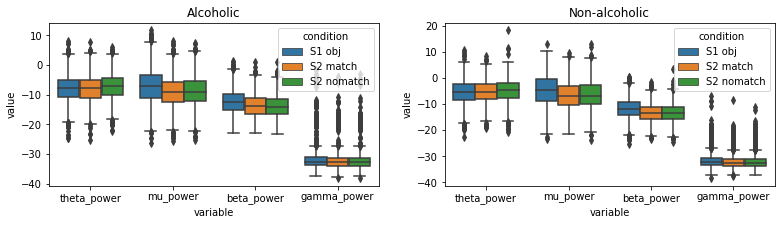

In [237]:
fig, axs = plt.subplots(1,2,figsize=(13,3))
sns.boxplot(x="variable", y="value", hue='condition', data=df_melt[df_melt['alcoholic'] == True], ax=axs[0])
axs[0].set_title('Alcoholic')
sns.boxplot(x="variable", y="value", hue='condition', data=df_melt[df_melt['alcoholic'] == False], ax=axs[1])
axs[1].set_title('Non-alcoholic')

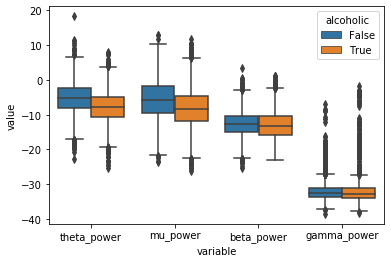

In [238]:
sns.boxplot(x="variable", y="value", hue='alcoholic', data=df_melt)
plt.show()

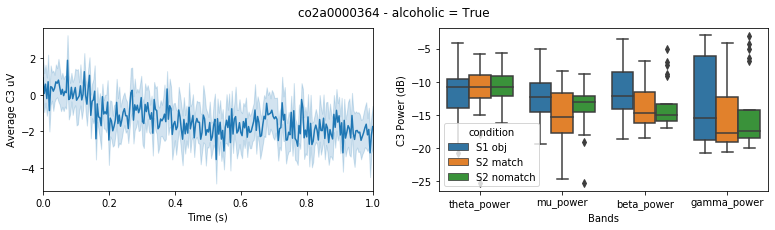

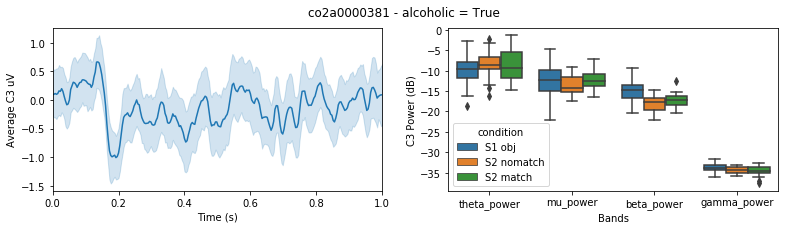

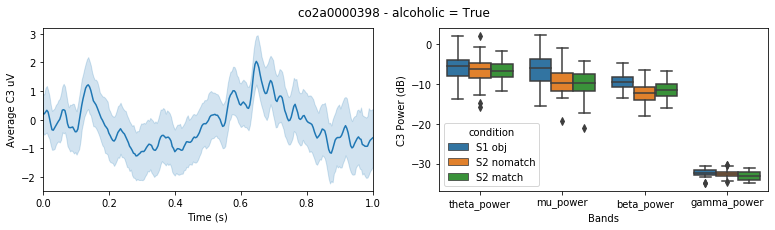

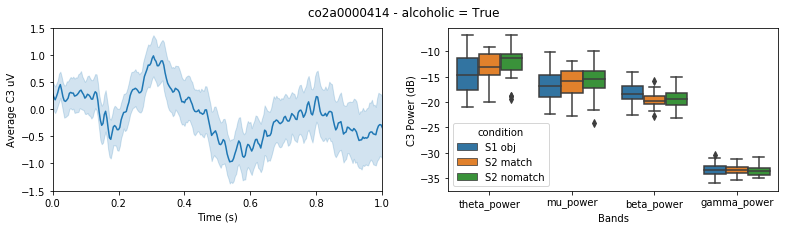

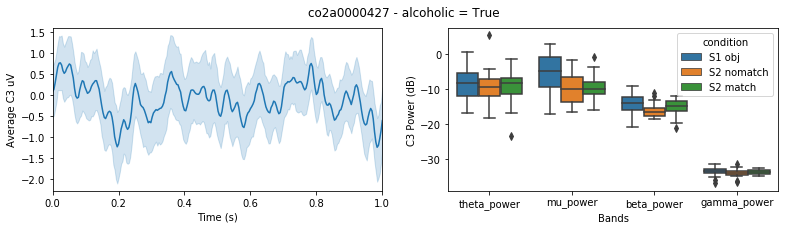

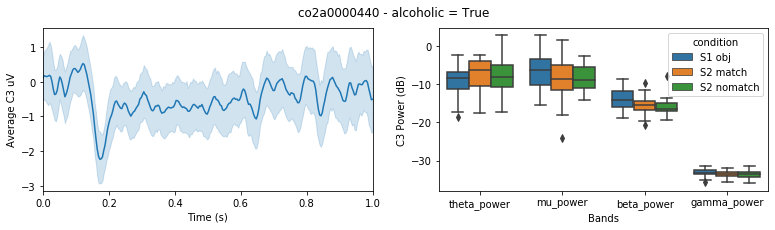

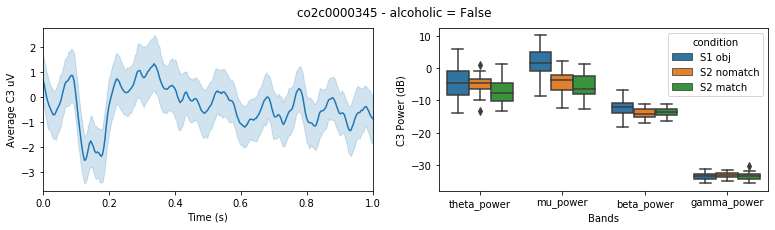

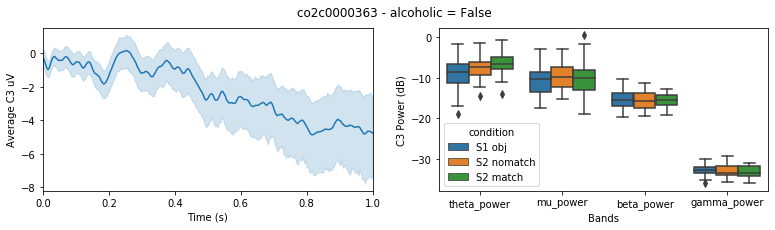

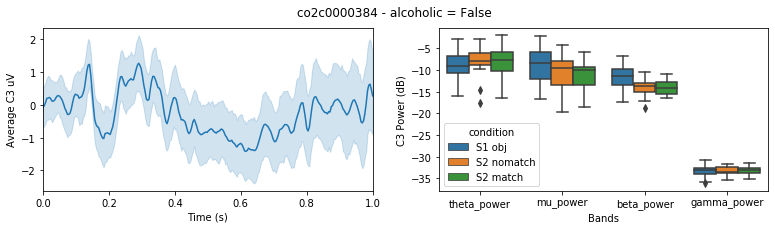

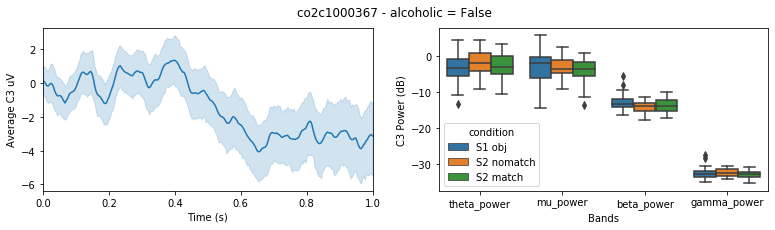

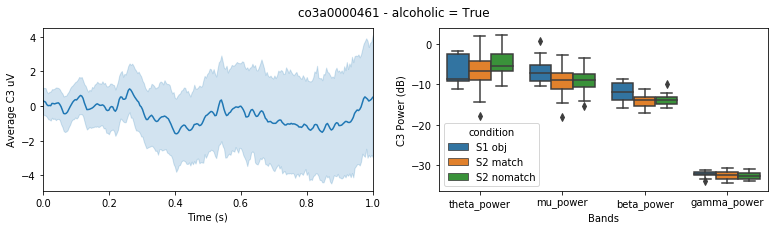

In [248]:
subs = df_melt['subject'].unique()
for sub in tqdm(subs[np.linspace(0,120,11).astype(int)]):
    df_sub = df_melt[df_melt['subject'] == sub]
    fig,axs=plt.subplots(1,2,figsize=(13,3))
    df_fullsub = pd.read_csv('data/alcoholism-01-parsed/' + sub + '.csv')
    sns.lineplot(x="time", y="C3", data=df_fullsub, ax=axs[0])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Average C3 uV')
    axs[0].set_xlim([0, 1])
    sns.boxplot(x="variable", y="value", hue='condition', data=df_sub, ax=axs[1])
    axs[1].set_xlabel('Bands')
    axs[1].set_ylabel('C3 Power (dB)')
    plt.suptitle(df_sub.iloc[0]['subject'] + ' - alcoholic = ' + str(df_sub.iloc[0]['alcoholic']))
    plt.show()

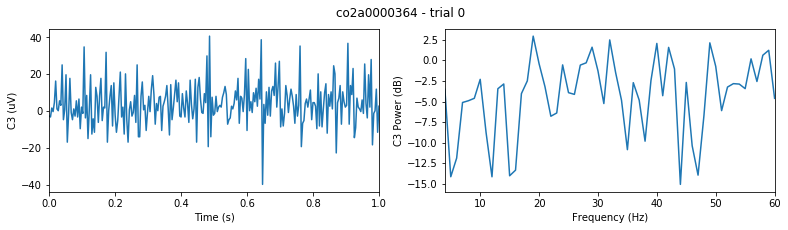

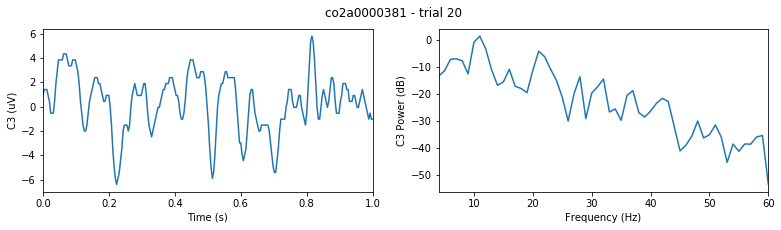

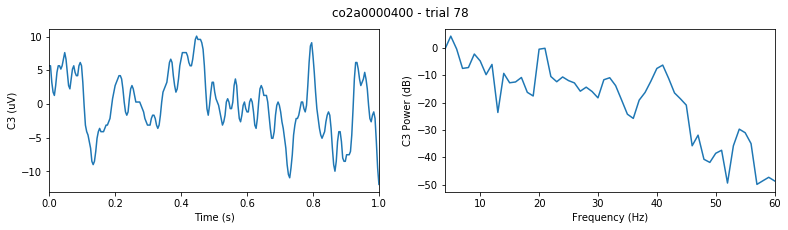

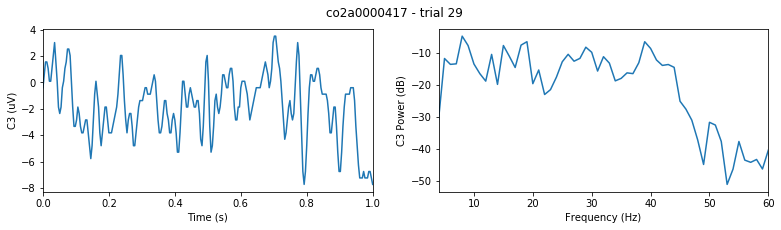

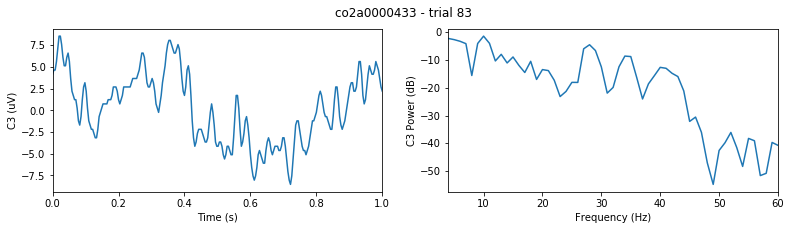

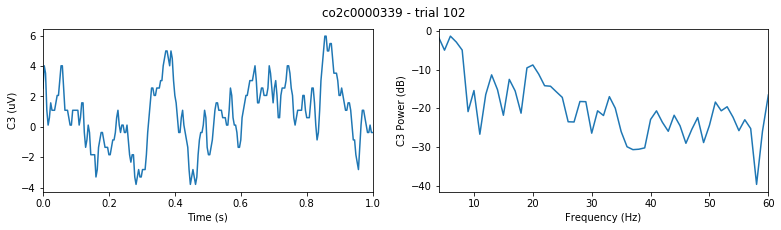

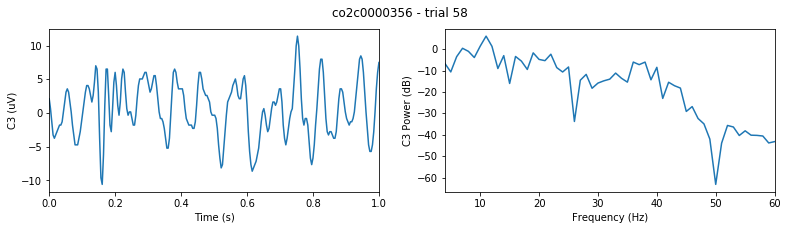

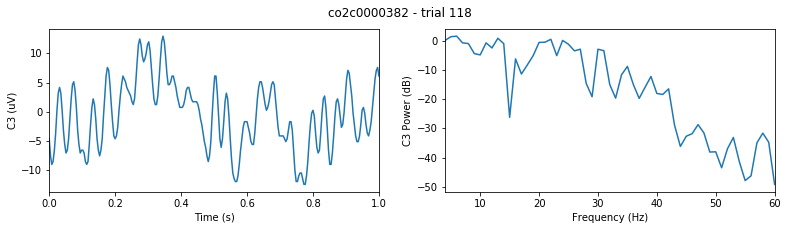

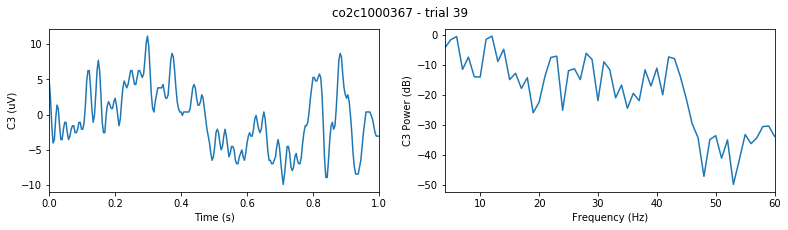

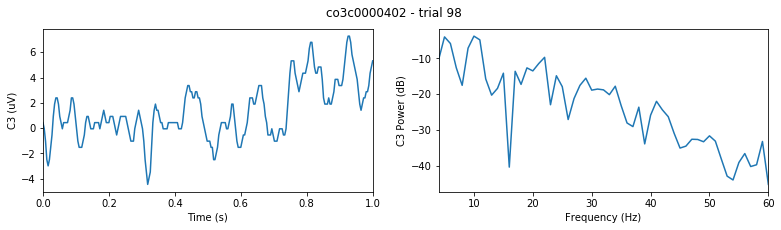

In [265]:
trial_files = sorted(glob.glob('data/alcoholism-02-for-matlab/*/*.csv'))
for trial_ind in tqdm(np.linspace(0,len(trial_files)-2,10).astype(int)):
    trial_file = trial_files[trial_ind]
    sub = trial_file.split('/')[2]
    trial = trial_file.split('/')[3].split('-')[1].split('.')[0]
    df_trial = pd.read_csv(trial_file)
    freq, power = signal.welch(df_trial['C3'].values, 256)
    df_psd = pd.DataFrame({'freq': freq, 'power': 10*np.log10(power)})
    df_psd = df_psd[df_psd['freq'] <= 60]
    df_psd = df_psd[df_psd['freq'] >=4]
    df_trial['time'] = np.linspace(0, 1, df_trial.shape[0])
    
    fig, axs=plt.subplots(1,2,figsize=(13,3))
    sns.lineplot(x="time", y="C3", data=df_trial, ax=axs[0])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('C3 (uV)')
    axs[0].set_xlim([0, 1])
    
    axs[1].plot(df_psd['freq'], df_psd['power'])
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('C3 Power (dB)')
    axs[1].set_xlim([4, 60])
    plt.suptitle(sub + " - trial " + trial)
    plt.show()